In [123]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from operator import attrgetter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

path = Path("../data")

In [59]:
df = pd.read_parquet(path / "full_data.parquet")

In [61]:
def get_cols_to_drop():

    drop_cols = [
                'churn',
                'advertiser_zrive_id',
                'period_int',
                'month_period',
                'monthly_avg_ad_price',                              
                'monthly_distinct_ads',
                ]

    return drop_cols

In [91]:
def split_by_date(data, execution_month, train_months = 6):
    """
    Splits data into train and test sets based on a date
    """
    df = data.sort_values('month_period')
    train_start = execution_month.to_timestamp() - pd.DateOffset(months=train_months)

    train = df[(df['month_period'] >= train_start.to_period('M')) & (df['month_period'] < execution_month)]
    test = df[df['month_period'] == execution_month]

    drop_cols = get_cols_to_drop()
    X_train = train.drop(columns=drop_cols, errors='ignore')
    y_train = train['churn']
    X_test = test.drop(columns=drop_cols, errors='ignore')
    y_test = test['churn']
    
    return X_train, X_test, y_train, y_test

In [ ]:
def train_model(model, X_train, y_train):
    """
    Trains model and evaluates using ROC AUC and PR AUC
    """

    model.fit(X_train, y_train)

    return model


In [67]:
def evaluate_model(y_test, y_scores):
 
    roc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    prc = auc(recall, precision)

    return {
        'roc_auc': roc,
        'pr_auc': prc,
    }

In [ ]:
def run_for_all_dates(data, model, execution_months, train_months = 6):
    """
    Rolls over execution_months, applies split, train and eval, returns results
    """
    results = []

    for execution_month in execution_months:
        X_train, X_test, y_train, y_test = split_by_date(data, execution_month, train_months)
        model = train_model(model,X_train, y_train)

        y_scores = model.predict_proba(X_test)[:, 1]
        
        metrics = evaluate_model(y_test, y_scores)
        metrics['execution_month'] = execution_month.to_timestamp()

        results.append(metrics)

    return pd.DataFrame(results),X_train, X_test


RANDOM FOREST

In [ ]:
execution_months = np.sort(df['month_period'].unique())[1:]
n_trees = [10, 50, 100, 200]
results = []

for trees in n_trees:
    model = RandomForestClassifier(trees)
    result,xtr,xte = run_for_all_dates(df, model, execution_months, train_months = 6)
    result['n_trees'] = trees
    results.append(result)
    all_results = pd.concat(results)


In [111]:
all_results_grouped = all_results.groupby('n_trees')

summary = pd.DataFrame({
    'roc_auc_mean': all_results_grouped.roc_auc.mean(),
    'roc_auc_std': all_results_grouped.roc_auc.std(),
    'pr_auc_mean': all_results_grouped.pr_auc.mean(),
    'pr_auc_std': all_results_grouped.pr_auc.std()
}).reset_index()

print(summary)


   n_trees  roc_auc_mean  roc_auc_std  pr_auc_mean  pr_auc_std
0       10      0.636251     0.040136     0.126303    0.032072
1       50      0.685988     0.046863     0.144846    0.034662
2      100      0.692831     0.046197     0.149930    0.038028
3      200      0.697442     0.048111     0.151628    0.037986


Results are not very promising, worse than logistic regression

Let's try removing features that could be unnecesary to see if the performance of the random forest improves

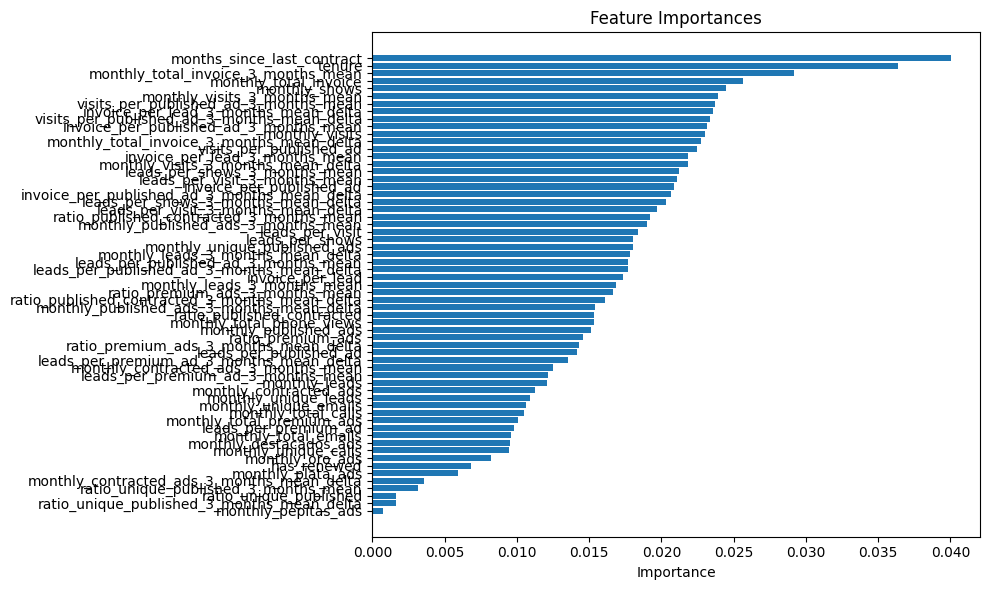

In [112]:
importances = model.feature_importances_
features = xtr.columns

# Crear un DataFrame para ordenar
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [113]:
important_features = feat_imp[feat_imp['Importance'] >= 0.02]['Feature'].tolist()
filtered_df = df[['churn', 'month_period'] + important_features]


In [160]:
execution_months = [pd.to_datetime('2023-11-01').to_period('M'), pd.to_datetime('2024-05-01').to_period('M')]
n_trees = [100]
results = []

for trees in n_trees:
    model = RandomForestClassifier(trees)
    result,xtr,xte = run_for_all_dates(filtered_df, model, execution_months, train_months = 6)
    result['n_trees'] = trees
    results.append(result)
    all_results = pd.concat(results)

In [165]:
all_results

,roc_auc,pr_auc,execution_month,n_trees
0,0.710736,0.144401,2023-11-01,100
1,0.725062,0.185407,2024-05-01,100


In [163]:
summary = pd.DataFrame({
    'roc_auc_mean': [all_results.roc_auc.mean()],
    'roc_auc_std': [all_results.roc_auc.std()],
    'pr_auc_mean': [all_results.pr_auc.mean()],
    'pr_auc_std': [all_results.pr_auc.std()]
})
print(summary)


   roc_auc_mean  roc_auc_std  pr_auc_mean  pr_auc_std
0      0.717899      0.01013     0.164904    0.028996


Results do not improve. Also very slow

LIGHTGBM

In [144]:
def run_for_all_dates_lgb(data, params, execution_months, train_months = 6):
    """
    Rolls over execution_months, applies split, train and eval, returns results
    """
    results = []

    for execution_month in execution_months:
        X_train, X_test, y_train, y_test = split_by_date(data, execution_month, train_months)


        train_data = lgb.Dataset(X_train, y_train)
        test_data = lgb.Dataset(X_test, y_test, reference=train_data)
        
        eval_result = {}
        model = lgb.train(params = params,
                            train_set =  train_data,
                            valid_sets=[test_data,train_data],
                            callbacks = [lgb.record_evaluation(eval_result = eval_result)])

        y_scores = model.predict(X_test)
        
        metrics = evaluate_model(y_test, y_scores)
        metrics['execution_month'] = execution_month.to_timestamp()

        results.append(metrics)

    return model,results,eval_result

In [ ]:
n_estimators = [20, 50, 100]
learning_rates = [0.01, 0.05, 0.1]
all_results = []

for learning_rate in learning_rates:
    for estimators in n_estimators:
        print(f'learning_rate: {learning_rate}, estimators: {estimators}')
        params = {
                'objective': 'binary',
                "verbosity": -1,
                'metric': 'binary_logloss',   
                "n_estimators": estimators,      
                'learning_rate': learning_rate,           
                }
        model,results,eval_result = run_for_all_dates_lgb(df, params, execution_months, train_months = 6)

        for r in results:
            r['learning_rate'] = learning_rate
            r['n_estimators'] = estimators
            all_results.append(r)

        

learning_rate: 0.01, estimators: 20
learning_rate: 0.01, estimators: 50
learning_rate: 0.01, estimators: 100
learning_rate: 0.05, estimators: 20
learning_rate: 0.05, estimators: 50
learning_rate: 0.05, estimators: 100
learning_rate: 0.1, estimators: 20
learning_rate: 0.1, estimators: 50
learning_rate: 0.1, estimators: 100


In [157]:
all_results_df = pd.DataFrame(all_results)

all_results_df

,roc_auc,pr_auc,execution_month,learning_rate,n_trees
0,0.653862,0.210469,2023-02-01,0.01,20
1,0.644739,0.156012,2023-03-01,0.01,20
2,0.692433,0.169285,2023-04-01,0.01,20
3,0.720859,0.185391,2023-05-01,0.01,20
4,0.735248,0.146517,2023-06-01,0.01,20
...,...,...,...,...,...
202,0.632120,0.167640,2024-08-01,0.10,100
203,0.764197,0.166845,2024-09-01,0.10,100
204,0.742209,0.180585,2024-10-01,0.10,100
205,0.620866,0.145848,2024-11-01,0.10,100


In [166]:
grouped = all_results_df.groupby(['learning_rate', 'n_trees'])[['roc_auc', 'pr_auc']].mean().reset_index()


In [167]:
grouped

,learning_rate,n_trees,roc_auc,pr_auc
0,0.01,20,0.713643,0.163161
1,0.01,50,0.720785,0.163386
2,0.01,100,0.722950,0.163670
3,0.05,20,0.720248,0.162195
4,0.05,50,0.723532,0.163035
5,0.05,100,0.721984,0.163125
6,0.10,20,0.721531,0.162523
7,0.10,50,0.717248,0.161077
8,0.10,100,0.711551,0.158609


In [156]:
pd.set_option('display.max_rows', 20)  # Show all rows
